# Object Detection to Instance Segmentation: Faster R-CNN to Mask R-CNN

You have learnt about **Faster R-CNN** [7] on the first week of this lecture series, when object detection was covered. Remember that Faster R-CNN [7] predicts bounding boxes and class scores for potential objects in the image.

**Mask R-CNN** [1] adds an extra branch into Faster R-CNN [7], which also predicts segmentation masks for each instance.

<img src="https://pythonawesome.com/content/images/2018/07/Mask-RCNN.png" alt="Mask R-CNN" width="500">

You will implement this extra branch, train the model, test it, and visualize the results.You will use PennFudan [2] dataset. 

## Question 1: Warm-up

You are highly encouraged to read Mask R-CNN [1] and Yolact [6] in addition to the lecture materials while seeking the answers to the questions below. 

* MNC: Multi-task Network Cascades [3] was covered during the lecture. What can be improved this network?

**Answer:** 

* RoIAlign vs. RoIPooling for instance segmentation 

**Answer:** 

* What is the loss function of Mark R-CNN [1]? Explain it.  

**Answer:** 

* Why is Mask R-CNN [1] better than FCN based approaches?

**Answer:** 

* Yolact [6] vs. Mask R-CNN [1]  

**Answer:** 

* Yolact [6] reports 1.6 AP at the 95% IoU threshold while Mask
R-CNN achieves 1.3. How can we explain better performance of Yolact [6] in that setting?    

**Answer:** 

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

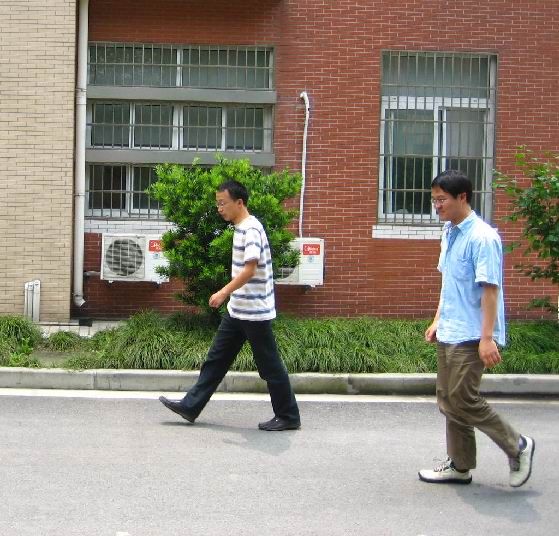

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

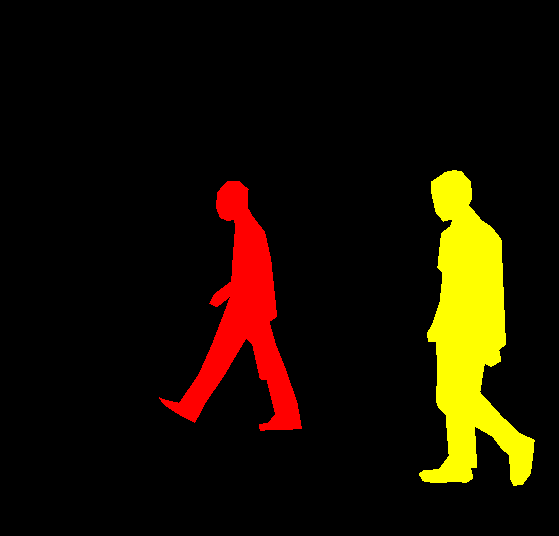

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

You can find how dataset for PennFudan [2] looks like below.
## Question 2
Given masks in an image in the dataset, find the bounding box coordinates of a mask.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            ##################################################################
            ###                      YOUR CODE STARTS                      ###
            ##################################################################
            # TODO: Given the masks, find the bounding box coordinate for each 
            # image and append to 'boxes'. See [8] for how bounding box
            # coordinates are represented.
            
            ##################################################################
            ###                       YOUR CODE ENDS                       ###
            ##################################################################

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

## Question 3
Implement transformations for images

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################
# TODO: train_transform should convert image into a PyTorch tensor, then apply
# at least two transforms for data augmentation

# TODO: test_transform should convert image into a PyTorch tensor

##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################

## Question 4
Keeping in mind our task and our dataset, briefly justify why you chose these specific transformations during data augmentation in Question 3

**Answer**:

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', train_transform())
dataset_test = PennFudanDataset('PennFudanPed', test_transform())

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

## Question 5
<img src="https://vipulvaibhaw.files.wordpress.com/2019/04/screenshot-2019-04-20-at-8.34.16-am.png?w=1100" alt="Mask R-CNN detailed" width="500">

Mask R-CNN [1] proposes two heads for mask detection. Implement below the one on the right (w/ FPN) on top of a pretrained Faster R-CNN [7]. Find Figure 4 in [1] for the details of the network. You might need to refer to other parts of the paper and [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) to find the parameters of some layers. Note that using mask_rcnn model in PyTorch is not allowed.

In [ ]:
import torchvision
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################

# TODO: Step 1 - Define RoI Align. Hint: check torchvision operators

# TODO: Step 2 - Add head

# TODO: Step 3 - Add predictor

##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################

my_mask = fasterrcnn
# You might be surprised to see that we do not put roi pool, head, and predictor 
# sequentially below but assign them to some layers instead. Note that we don't 
# have to do it as torchvision does it for us and puts them in sequential order 
# internally in this case.
my_mask.roi_heads.mask_roi_pool = mask_roi_pool
my_mask.roi_heads.mask_head = mask_head
my_mask.roi_heads.mask_predictor = mask_predictor

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = my_mask
# move model to the right device
model.to(device)

## Question 6
Construct an optimizer.

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################

##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################

In [ ]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 100 epochs
num_epochs = 100

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [ ]:
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

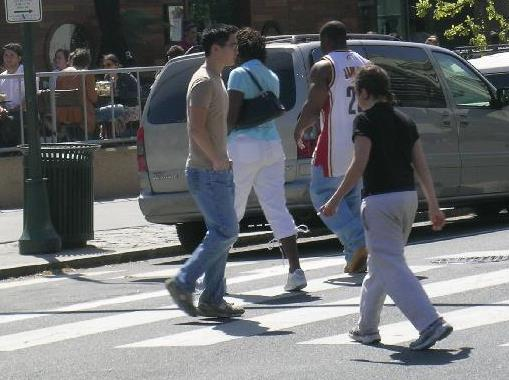

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

## Question 7
Given mask of an object, colorize the mask. 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings

"""
Given a mask for an object, return coloured mask. Shape of the given mask is
(H, W), so the shape of returned mask should be (3, H, W).
"""
def get_coloured_mask(mask):
    ##################################################################
    ###                      YOUR CODE STARTS                      ###
    ##################################################################

    # TODO: Assign a color to the given mask. Bonus: assign distinct colors to
    # each masks

    # TODO: Masks you receive might contain noise, so apply a threshold.

    ##################################################################
    ###                       YOUR CODE ENDS                       ###
    ##################################################################
    
    return coloured_mask

## Question 8
Visualize the image, masks, and bounding boxes. You can expect non-perfect masks.  

Optional: If you want better masks, change your training strategy! (changing # of epochs, different optimizer etc.)

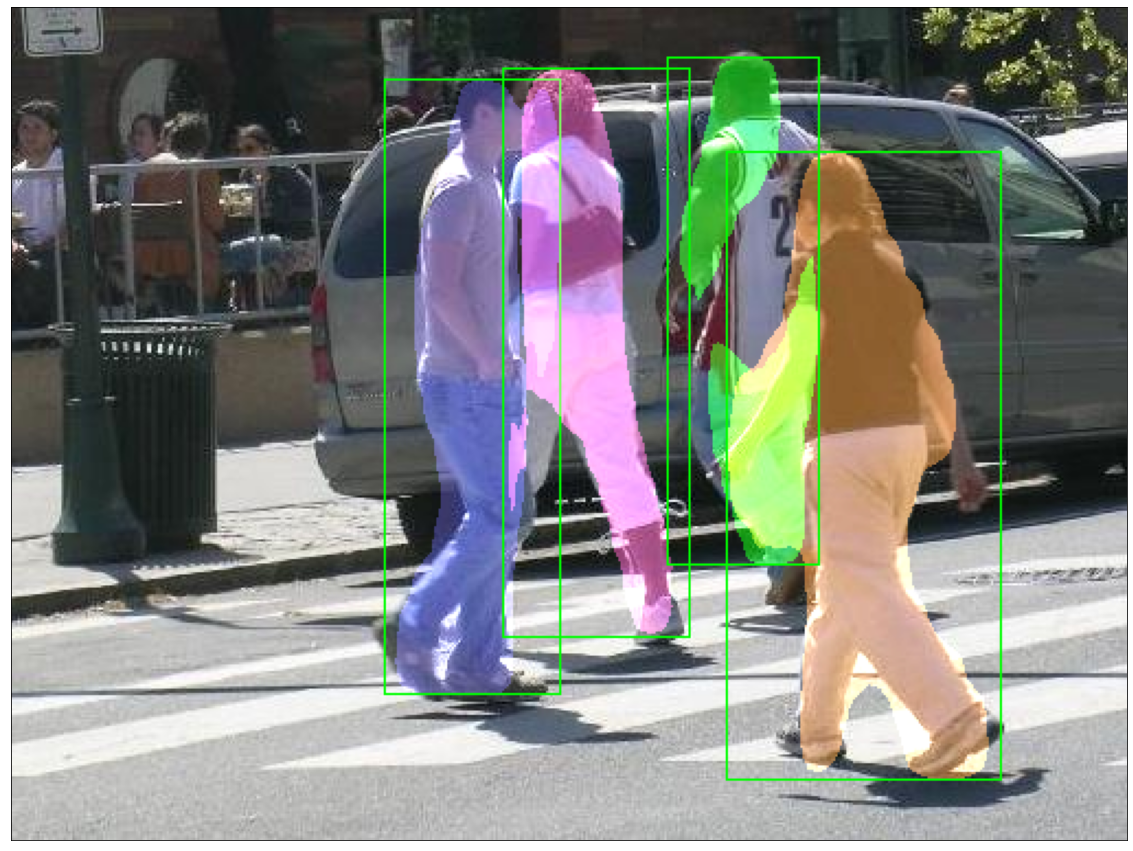

In [ ]:
%matplotlib inline

def vis_instance(img):
    img = img.mul(255).permute(1, 2, 0).byte().numpy()
    scores = prediction[0]['scores'].tolist()
    for i in range(len(scores)):
      box = prediction[0]['boxes'][i].cpu().numpy()
      mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
      rgb_mask = get_coloured_mask(mask)
      ##################################################################
      ###                      YOUR CODE STARTS                      ###
      ##################################################################
      # TODO: Add image and RGB mask on top of each other. Hint: check cv2
      # operations

      # TODO: Add a rectangle around the instances. Hint: check cv2 drawing
      # functions
      
      ##################################################################
      ###                       YOUR CODE ENDS                       ###
      ##################################################################
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

vis_instance(img)

# References

[1] K. He, G. Gkioxari, P. Dollar, and R. Girshick. Mask R-CNN. ICCV, 2017.   
[2] https://www.cis.upenn.edu/~jshi/ped_html/  
[3] J. Dai, K. He, and J. Sun. Instance-aware Semantic Segmentation via Multi-task Network Cascades. CVPR, 2016.  
[4] R. Girshick. Fast R-CNN. ICCV, 2015.   
[5] J. Long, E. Shelhamer, and T. Darrell. Fully convolutional networks for semantic segmentation. CVPR, 2015.   
[6] D. Bolya, C. Zhou, F. Xiao, Y. Jae Lee. YOLACT: Real-time Instance Segmentation. ICCV, 2019    
[7] Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. S. Ren, K. He, R. Girshick, J. Sun. NIPS, 2015    
[8] https://d2l.ai/chapter_computer-vision/bounding-box.html#bounding-box